In [166]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [250]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from time import time
from numpy import array

from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Model
from keras.applications.inception_v3 import preprocess_input

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import add
from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras import Input
from tensorflow.keras import optimizers

from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import load_model

import nltk.translate.bleu_score as bleu

In [168]:
df = pd.read_csv("/content/gdrive/MyDrive/Image_Captioning/captions.txt")
df.head(5)

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [169]:
train, val = np.split(df.sample( frac=1,random_state=42), [int(.8*len(df)),])
print(len(df), train.shape, val.shape)

40455 (32364, 2) (8091, 2)


In [170]:
image_path = '/content/gdrive/MyDrive/Image_Captioning/Images'

95                   A man drilling a hole in the ice .
96    A man is drilling through the frozen ice of a ...
97    A person in the snow drilling a hole in the ice .
98                 A person standing on a frozen lake .
99                            Two men are ice fishing .
Name: caption, dtype: object


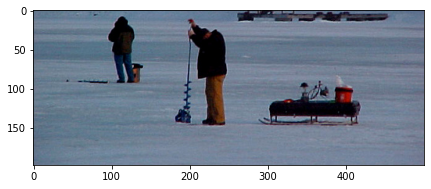

In [171]:
n = 19
img = Image.open(image_path + '/' + df['image'][5*n])
plt.figure(figsize=(7, 7))
plt.imshow(img)
print(df['caption'][5*n:5*n+5])

In [172]:
for i in range(5):
  img = Image.open(image_path + '/' + df['image'][i])
  print(img.size)

(375, 500)
(375, 500)
(375, 500)
(375, 500)
(375, 500)


# **2. Preprocessing captions**

In [173]:
import re
def caption_preprocessing(text, remove_digits=True):
  pattern=r'[^a-zA-z0-9\s]'
  text=re.sub(pattern,'',text)
  # tokenize
  text=text.split()
  # convert to lower case
  text = [word.lower() for word in text]
  # remove hanging 's' and 'a'
  # text = [word for word in text if len(word)>1]
  
  # remove tokens with numbers in them
  text = [word for word in text if word.isalpha()]
  # store as string
  text =  ' '.join(text)

  # insert 'startseq', 'endseq' cho chuỗi
  text = 'startseq ' + text + ' endseq'
  return text


In [174]:
print(caption_preprocessing('chao .. ban $ hello980 it\'s a table.#'))

startseq chao ban its a table endseq


In [175]:
df['caption'] = df['caption'].apply(caption_preprocessing)

In [176]:
df['caption']

0        startseq a child in a pink dress is climbing u...
1        startseq a girl going into a wooden building e...
2        startseq a little girl climbing into a wooden ...
3        startseq a little girl climbing the stairs to ...
4        startseq a little girl in a pink dress going i...
                               ...                        
40450    startseq a man in a pink shirt climbs a rock f...
40451    startseq a man is rock climbing high in the ai...
40452    startseq a person in a red shirt climbing up a...
40453        startseq a rock climber in a red shirt endseq
40454    startseq a rock climber practices on a rock cl...
Name: caption, Length: 40455, dtype: object

# **Count the number of worrds in dataset and max_length of captions**

In [177]:
word_counts = {}
max_length = 0
for text in df['caption']:
  words = text.split()
  max_length = len(words) if (max_length < len(words)) else max_length
  for w in words:
    try:
      word_counts[w] +=1
    except:
        word_counts[w] = 1
print(len(word_counts))
print(max_length)

8777
37


In [178]:
# Chỉ lấy các từ xuất hiện trên 2 lần
#word_count_threshold = 2
#vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
#print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))
vocab = word_counts

In [179]:
i2w = {} #index to word
w2i = {} #word to index

id = 1
for w in vocab:
    w2i[w] = id
    i2w[id] = w
    id += 1

print(len(i2w), len(w2i))
print(i2w[300])

8777 8777
item


# **Embedding word using Glove**

In [180]:
! wget https://nlp.stanford.edu/data/glove.6B.zip

--2023-03-09 12:44:49--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-03-09 12:44:49--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 40s  

2023-03-09 12:47:30 (5.13 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [181]:
! mkdir glove
! unzip glove.6B.zip -d glove

Archive:  glove.6B.zip
  inflating: glove/glove.6B.50d.txt  
  inflating: glove/glove.6B.100d.txt  
  inflating: glove/glove.6B.200d.txt  
  inflating: glove/glove.6B.300d.txt  


In [182]:
glove_dir = '/content/glove'
embeddings_index = {} # empty dictionary
file = open(glove_dir + '/' + 'glove.6B.200d.txt', encoding="utf-8")

for line in file:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
file.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [183]:
embeddings_index['girl'].shape

(200,)

In [184]:
embedding_dim = 200
vocab_size = len(vocab) + 1 # thêm 1 padding

In [185]:
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in w2i.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(8778, 200)


In [186]:
from pickle import dump, load

In [187]:
with open("/content/gdrive/MyDrive/Image_Captioning/embedding_matrix.pkl", "wb") as file:
    dump(embedding_matrix, file)

In [188]:
embedding_matrix = load(open("/content/gdrive/MyDrive/Image_Captioning/embedding_matrix.pkl", "rb"))
embedding_matrix.shape

(8778, 200)

# **Transfer learning on images, using Inception V3**

In [189]:
model = InceptionV3()

In [190]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [191]:
# Tạo model mới, bỏ layer cuối từ inception v3
model_new = Model(model.input, model.layers[-2].output)

In [192]:
model_new.input_shape

(None, 299, 299, 3)

In [193]:
images = {}
captions = {}

start = time()
for i in range(len(df)):
    images[df['image'][i]] = np.array(Image.open(image_path + '/' + df['image'][i]))
    try:
      captions[df['image'][i]].append(df['caption'][i])
    except:
      captions[df['image'][i]] = [df['caption'][i]]
  
print(len(images), len(captions))
print('Time: ',time() - start)

8091 8091
Time:  1535.959243297577


In [194]:
with open("/content/gdrive/My Drive/Image_Captioning/encoded_captions.pkl", "wb") as file:
    dump(captions, file)

In [195]:
captions = load(open("/content/gdrive/My Drive/Image_Captioning/encoded_captions.pkl", "rb"))
len(captions)

8091

In [196]:
images[df['image'][0]].shape

(500, 375, 3)

In [197]:
# Image embedding thành vector (2048, )
def encode(image):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = np.resize(image, (299, 299, 3 ))
    # Add one more dimension
    img = np.expand_dims(img, axis=0)
    # preprocess the images using preprocess_input() from inception module
    img = preprocess_input(img)

    fea_vec = model_new.predict(img) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [198]:
# Gọi hàm encode với các ảnh trong traning set
start = time()
encoding_image = {}
for id, img in images.items():
    encoding_image[id] = encode(img)
print("Time taken in seconds =", time()-start)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
1/1 [==============================] - 0s 30ms/step
Time taken in seconds = 634.296403169632


In [199]:
encoding_image['2089542487_b4c1ee7025.jpg'].shape

(2048,)

In [200]:
train_features = encoding_image

In [201]:
with open("/content/gdrive/My Drive/Image_Captioning/encoded_train_images.pkl", "wb") as file:
    dump(encoding_image, file)

In [202]:
train_features = load(open("/content/gdrive/My Drive/Image_Captioning/encoded_train_images.pkl", "rb"))
len(train_features)

8091

# **Training**

In [203]:
def data_generator(captions, images, w2i, max_length, batch_size):

  X_image, X_cap, y = [], [], []
  n = 0
  while 1:
    for id, caps in captions.items():
      n += 1
      image = images[id]
      for cap in caps:
        # encode the sequence
        seq = [w2i[word] for word in cap.split(' ') if word in w2i]

        for i in range(1, len(seq)):
          # split into input and output pair
          in_seq, out_seq = seq[:i], seq[i]
          
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          # encode output sequence
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          
          # store
          X_image.append(image)
          X_cap.append(in_seq)
          y.append(out_seq)
      if n == batch_size:
          yield ([np.array(X_image), np.array(X_cap)], np.array(y))
          X_image, X_cap, y = [], [], []
          n = 0

In [204]:
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs_1 = Input(shape=(2048,))
    fe_1 = Dropout(0.5)(inputs_1)
    fe_2 = Dense(256, activation='relu')(fe_1)
    # sequence model
    inputs_2 = Input(shape=(max_length,))
    se_1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs_2)
    se_2 = Dropout(0.5)(se_1)
    se_3 = LSTM(256)(se_2)
    # decoder model
    decoder_1 = add([fe_2, se_3])
    decoder_2 = Dense(256, activation='relu')(decoder_1)
    outputs = Dense(vocab_size, activation='softmax')(decoder_2)
    # tie it together [image, sequence] [word]
    model = Model(inputs=[inputs_1, inputs_2], outputs=outputs)
    return model

In [205]:
# max_length = 35, vocab_size = 2005, embedding_dim = 200
model = define_model(vocab_size, max_length)

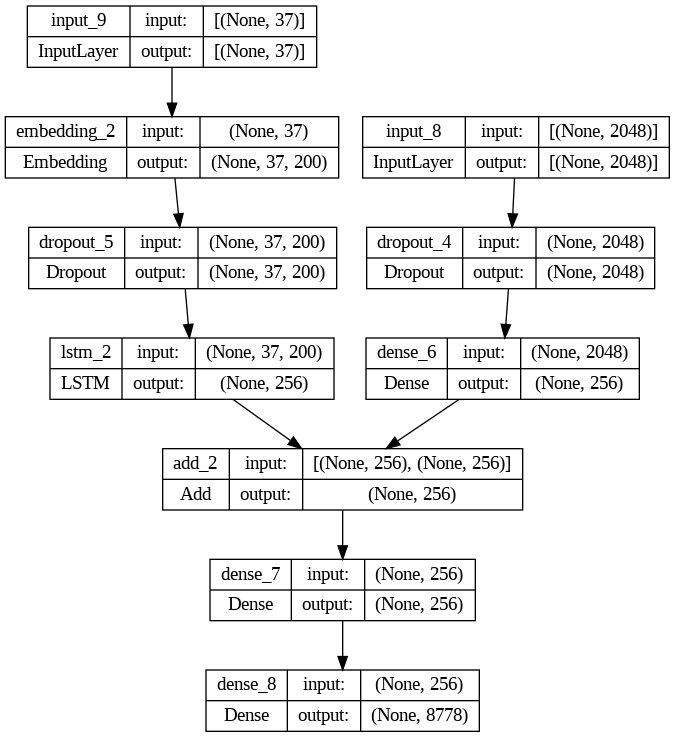

In [206]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [207]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 37)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 37, 200)      1755600     ['input_9[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 2048)         0           ['input_8[0][0]']                
                                                                                            

In [208]:
# Layer 2 dùng GLOVE Model nên set weight thẳng và không cần train
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [209]:
model.optimizer.learning_rate = 0.001
epochs = 5
batch_size = 32
steps = len(train_features)

In [210]:
checkpoint_path = "/content/gdrive/MyDrive/Image_Captioning/cp.ckpt"

In [211]:
cp_callback = ModelCheckpoint(filepath=checkpoint_path,save_best_only=False, save_weights_only=True, verbose=1)

In [212]:
generator = data_generator(captions=captions, images=train_features, w2i=w2i, max_length=max_length, batch_size=batch_size)
history = model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1, callbacks=[cp_callback])

Epoch 1/5
8091/8091 [==============================] - ETA: 0s - loss: 2.7842 - accuracy: 0.3861
Epoch 1: saving model to /content/gdrive/MyDrive/Image_Captioning/cp.ckpt
8091/8091 [==============================] - 1444s 178ms/step - loss: 2.7842 - accuracy: 0.3861
Epoch 2/5
8091/8091 [==============================] - ETA: 0s - loss: 2.2348 - accuracy: 0.4473
Epoch 2: saving model to /content/gdrive/MyDrive/Image_Captioning/cp.ckpt
8091/8091 [==============================] - 1452s 180ms/step - loss: 2.2348 - accuracy: 0.4473
Epoch 3/5
8091/8091 [==============================] - ETA: 0s - loss: 2.1136 - accuracy: 0.4649
Epoch 3: saving model to /content/gdrive/MyDrive/Image_Captioning/cp.ckpt
8091/8091 [==============================] - 1434s 177ms/step - loss: 2.1136 - accuracy: 0.4649
Epoch 4/5
8091/8091 [==============================] - ETA: 0s - loss: 2.0458 - accuracy: 0.4752
Epoch 4: saving model to /content/gdrive/MyDrive/Image_Captioning/cp.ckpt
8091/8091 [=================

In [213]:
model.save_weights('/content/gdrive/MyDrive/Image_Captioning/model.h5')

In [214]:
model.save('/content/gdrive/MyDrive/Image_Captioning/model.h5')

# **Load model and inference**

In [215]:
model_new = load_model('/content/gdrive/MyDrive/Image_Captioning/model.h5')

In [216]:
model_new.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 37)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 37, 200)      1755600     ['input_9[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 2048)         0           ['input_8[0][0]']                
                                                                                            

In [217]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [w2i[w] for w in in_text.split() if w in w2i]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model_new.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = i2w[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

---------------------Actual---------------------
12540    startseq the two small dogs run through the gr...
12541    startseq two fluffy white dogs running in gree...
12542    startseq two small dogs run through the grass ...
12543    startseq two small dogs that look almost ident...
12544    startseq two yellow dogs run together in green...
Name: caption, dtype: object
--------------------Predicted--------------------
a dog emerging through the grass


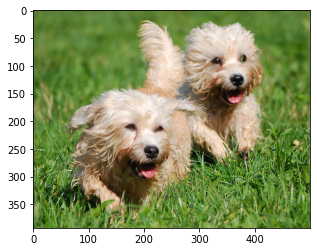

In [248]:
pic = list(train_features.keys())[2508]
image = train_features[pic].reshape((1,2048))
img = Image.open(image_path + '/' + pic)
print('---------------------Actual---------------------')
print(df['caption'][df['image'] == pic])

predict = greedySearch(image)
print('--------------------Predicted--------------------')
print(predict)

plt.imshow(img)
plt.show()

In [249]:
print("BLEU Score : ",bleu.sentence_bleu(df['caption'][df['image'] == pic], predict)) 
#BLEU Score :  0.6532673371066658 - 7800
#BLEU Score :  0.4703539723105089 - 50
#BLEU Score :  0.6231669047844632 - 69
#BLEU Score :  0.3700269179883926 - 999

BLEU Score :  0.39788115731740237
